In [1]:
%matplotlib notebook
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astroquery.irsa_dust import IrsaDust
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.optimize import curve_fit
import sncosmo
import sys
import tables

In [2]:
# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry
# P48
lc = dict()
for filter_name in ["g", "R"]:
    key = "P48_%s" % filter_name
    data = np.array([(row["time"], row["flux"], row["flux_err"])
                     for row in table.where(
                         "(telescope == b'P48') & (filter_name == b'%s')" % filter_name)
                    ],
                    dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
    np.sort(data, order=["time"])
    lc[key] = data
# P60 light curve
for filter_name in ["g", "r", "i"]:
    key = "P60_%s" % filter_name
    data = np.array([(row["time"], row["flux"], row["flux_err"])
                     for row in table.where(
                         u"(telescope == b'P60') & (filter_name == b'%s')" % filter_name)
                    ],
                    dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
    np.sort(data, order=["time"])
    lc[key] = data

In [43]:
# data from Piro & Morozova models
from astropy.table import Table
Piro_col_names = ("Time", "Teff", 
                  "PTF_R", 
                  "u", "g", "r", "i", "z", 
                  "U", "B", "V", "R", "I")

dat = Table.read("Piro_models/ia_mixing/magnitudes_0.25.dat", 
                 format = "ascii", names = Piro_col_names)

<IPython.core.display.Javascript object>


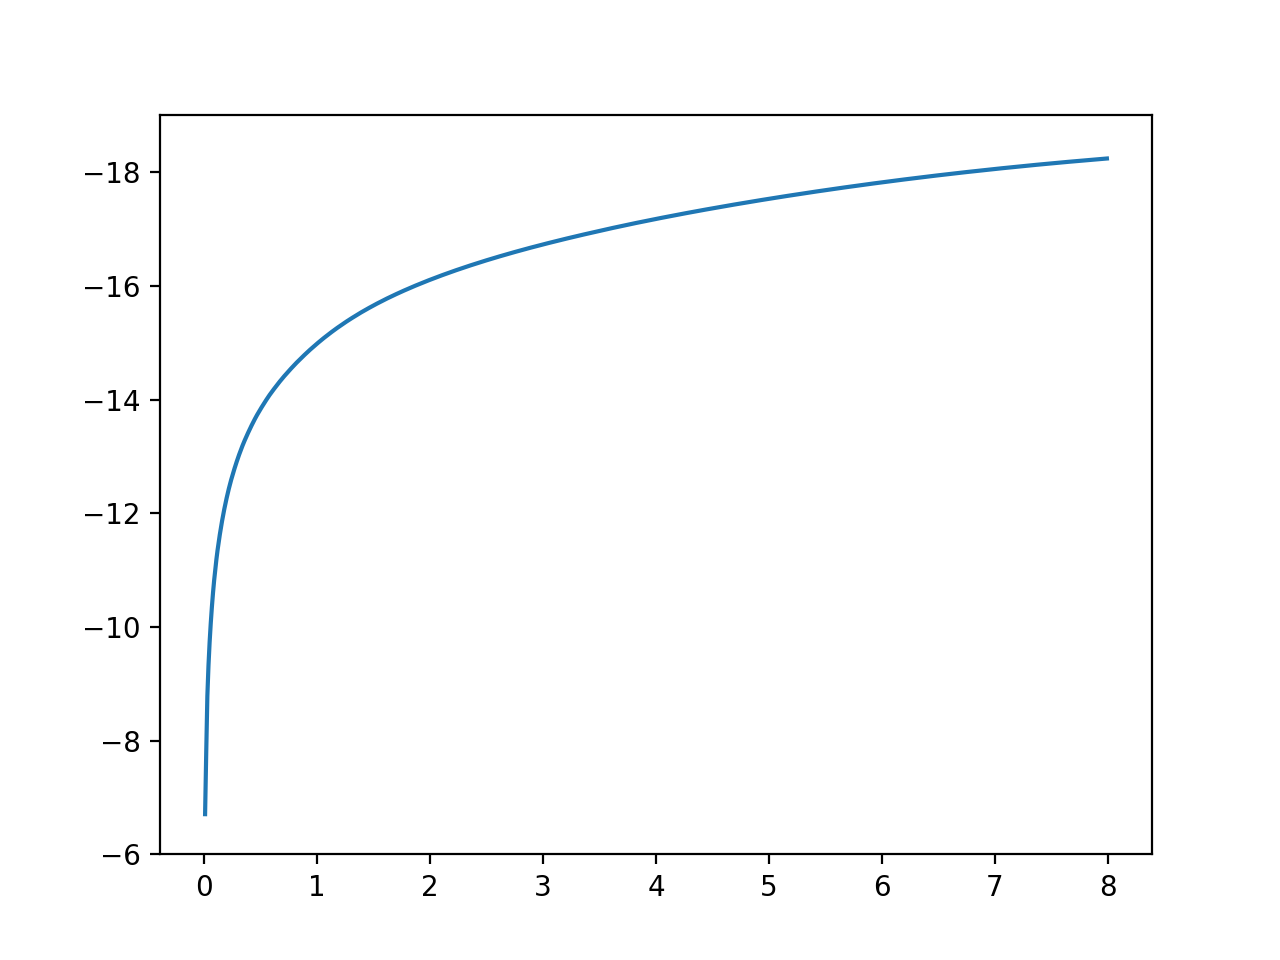

(-6, -19)

In [24]:
plt.plot(dat["Time"]/86400, dat["g"])
plt.ylim(-6, -19)

In [56]:
# properties iPTF16abc
z = 0.00232
mu = 34.66
t = 0.18  # days. First detection of iPTF16abc
mag = 21.4  # mag. First mag of iPTF16abc
local_EBV = 0.07
galactic_EBV = 0.0279

A_g = 0.41 # assuming E(B-V)_SFD = 0.0979/0.78

T_MAX = 57499.65
T_0 = T_MAX - 18.7

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


<IPython.core.display.Javascript object>


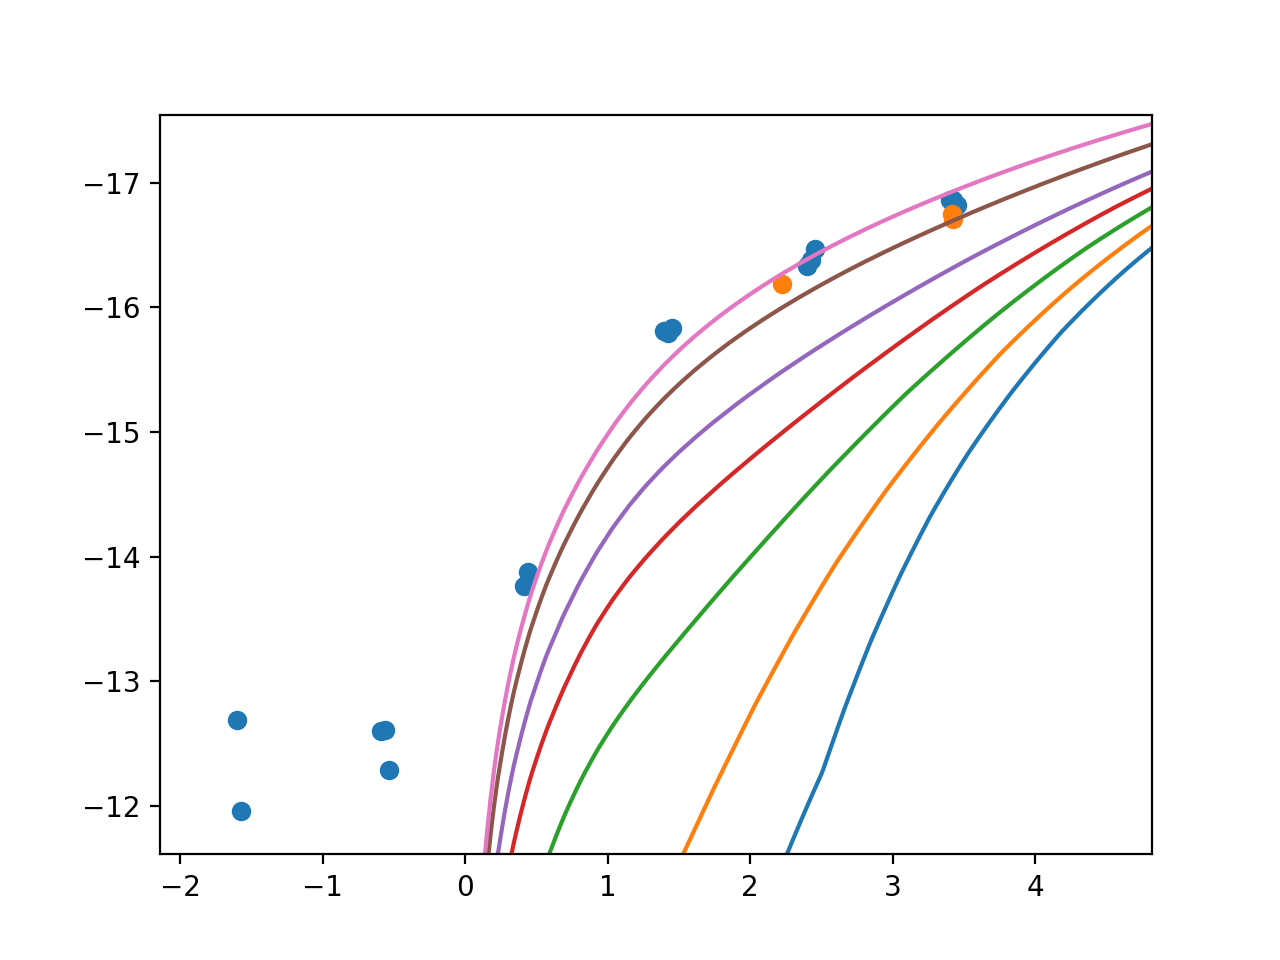

(-6, -19)

In [57]:
import glob
Ni_files = glob.glob("Piro_models/ia_mixing/*dat")
g_mag = -2.5*np.log10(lc['P48_g']['flux']*1.e-23)-48.6
g60_mag = -2.5*np.log10(lc['P60_g']['flux']*1.e-23)-48.6
plt.scatter(lc['P48_g']['time'] - T_0, g_mag - mu - A_g)
plt.scatter(lc['P60_g']['time'] - T_0, g60_mag - mu - A_g)
for mixing in Ni_files:
    dat = Table.read(mixing, format = "ascii", names = Piro_col_names)
    plt.plot(dat["Time"]/86400, dat["g"])
plt.ylim(-6,-19)

In [66]:
# LCOGT g-band light curve

for filter_name in ["g", "r", "i"]:
    key = "LCOGT-1m_%s" % filter_name
    data = np.array([(row["time"], row["flux"], row["flux_err"])
                     for row in table.where(
                         u"(telescope == b'LCOGT-1m') & (filter_name == b'%s')" % filter_name)
                    ],
                    dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
    np.sort(data, order=["time"])
    lc[key] = data



<IPython.core.display.Javascript object>


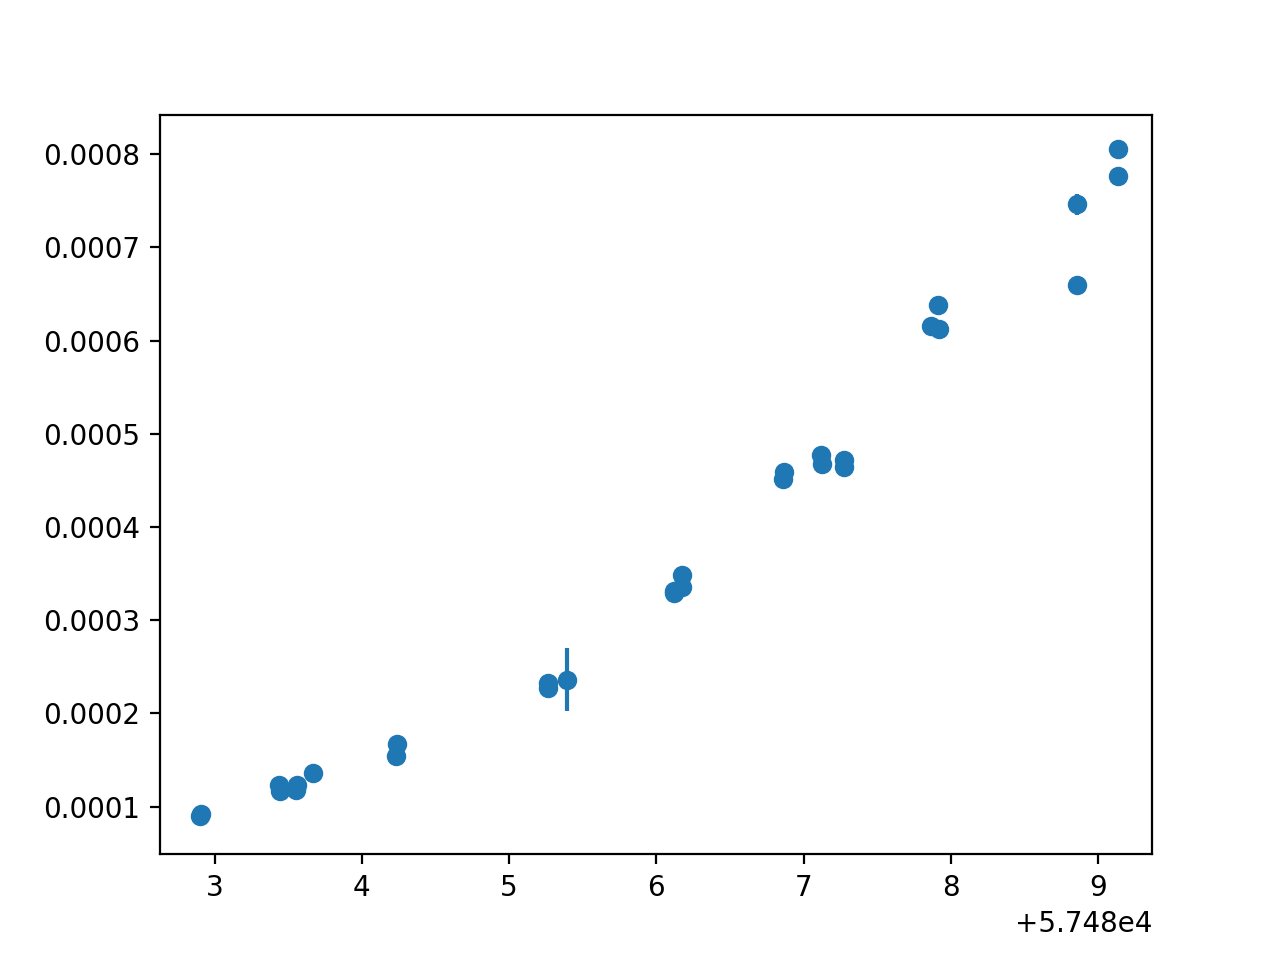

<Container object of 3 artists>

In [73]:
plt.errorbar(*zip(*lc['LCOGT-1m_g']), fmt = 'o')

In [74]:
# convert M_g to flux
mu = 34.7289 
A_g = 0.41
M_g = dat["g"]
m_g = M_g + mu + A_g
flux = 10**(-0.4*m_g)*3631


<IPython.core.display.Javascript object>


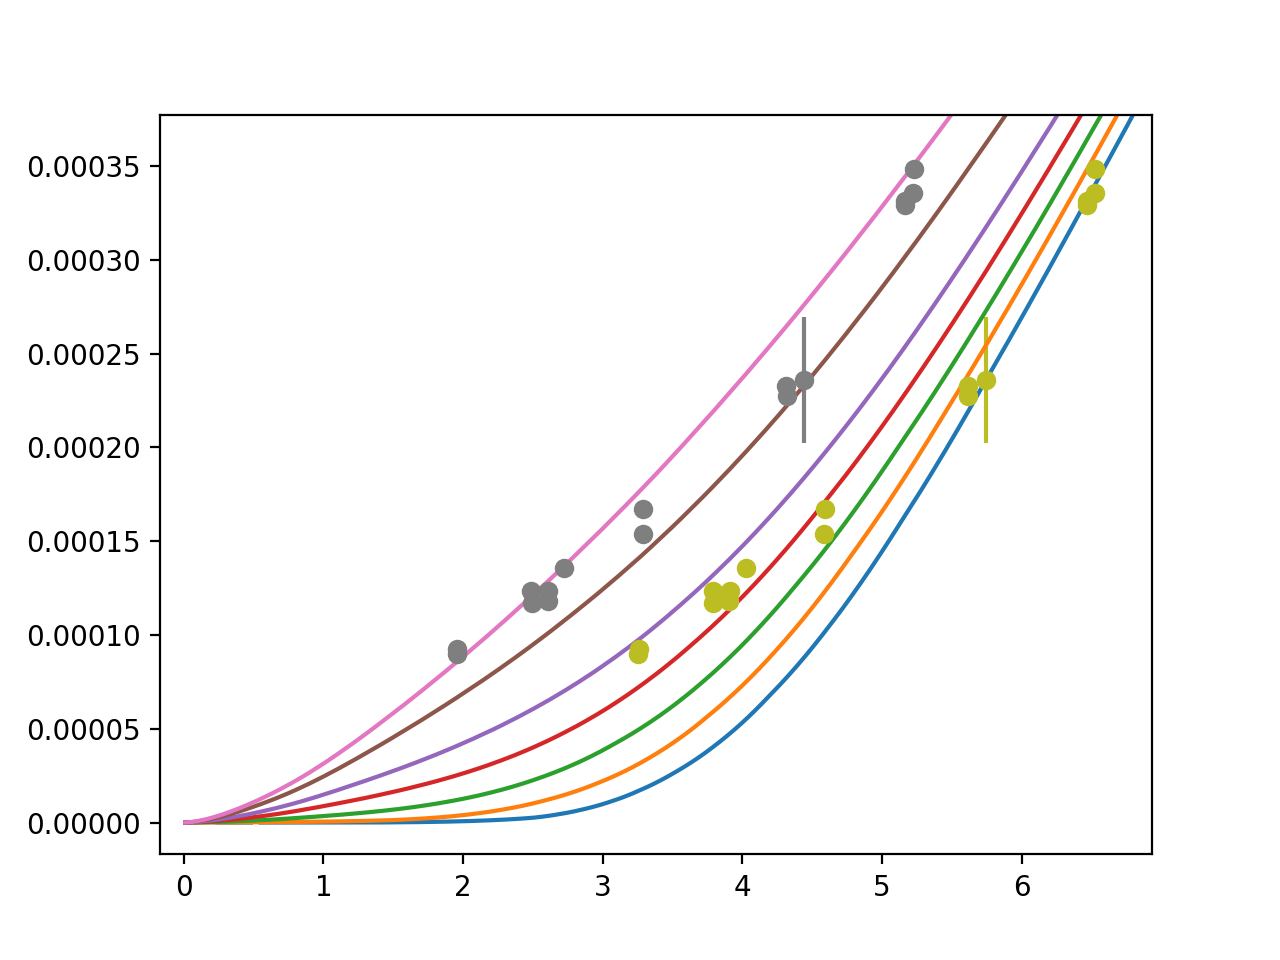

<Container object of 3 artists>

In [94]:
base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = Piro_col_names)
    M_g = dat["g"]
    m_g = M_g + mu + A_g
    flux = np.power(10,(-0.4*m_g))*3631
    plt.plot(dat["Time"]/86400, flux)

plt.errorbar(lc['LCOGT-1m_g']['time'] - T_0, lc['LCOGT-1m_g']['flux'], lc['LCOGT-1m_g']['flux_err'], fmt = 'o')
plt.errorbar(lc['LCOGT-1m_g']['time'] - T_0 + 1.3, lc['LCOGT-1m_g']['flux'], lc['LCOGT-1m_g']['flux_err'], fmt = 'o')



<IPython.core.display.Javascript object>


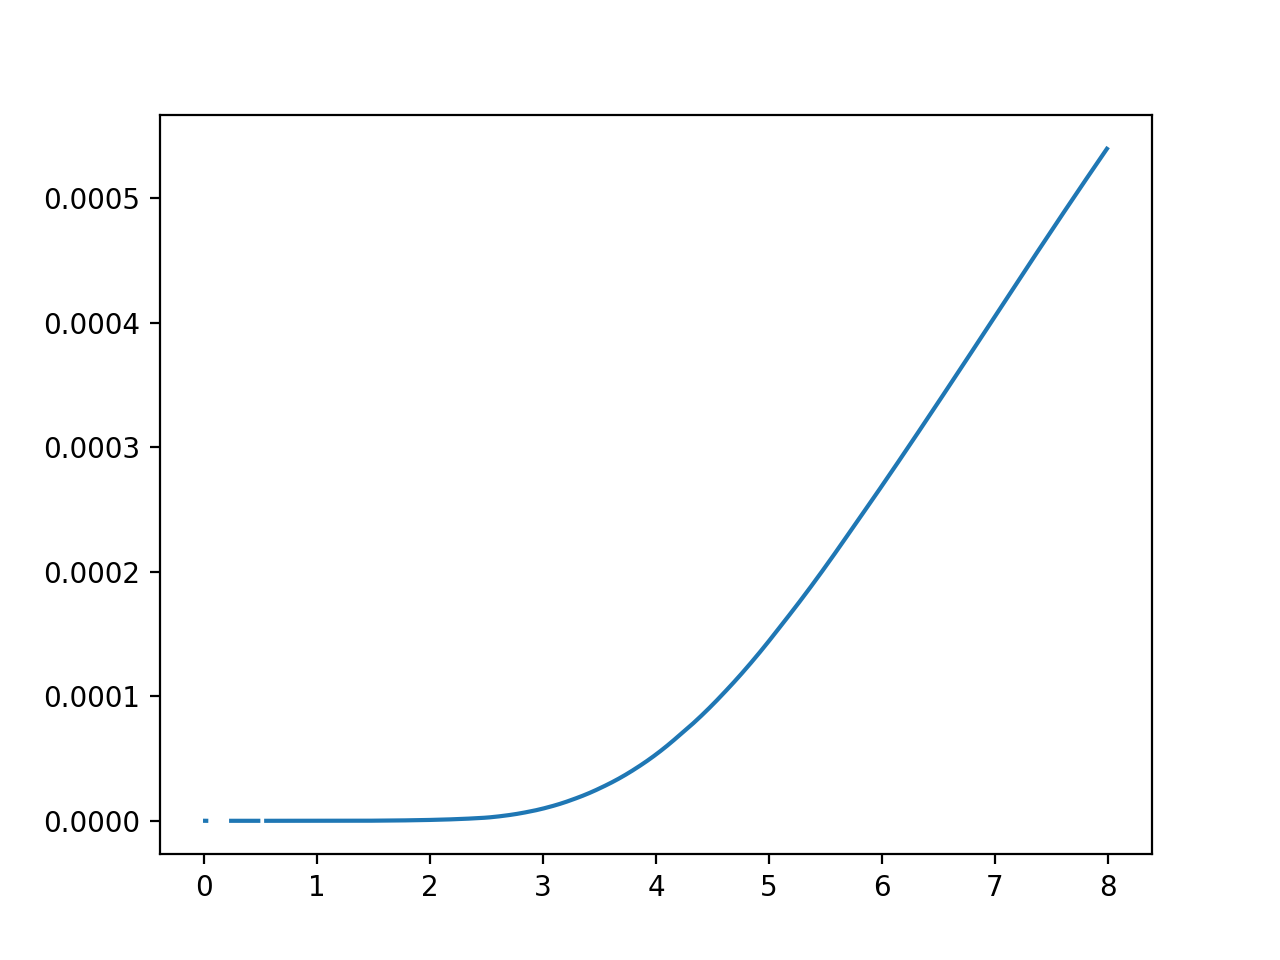

In [90]:
plt.figure()
plt.plot(dat["Time"]/86400, flux)